In [1]:
# import tarfile


# fname = 'fer2013.tar.gz'
# if fname.endswith("tar.gz"):
#     tar = tarfile.open(fname, "r:gz")
#     tar.extractall()
#     tar.close()
# elif fname.endswith("tar"):
#     tar = tarfile.open(fname, "r:")
#     tar.extractall()
#     tar.close()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
df = pd.read_csv('/content/drive/MyDrive/face_emotion/Dataset/ckextended.csv')
df.head()

,emotion,pixels,Usage
0,6,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,6,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,6,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,6,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,6,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


In [5]:
df['emotion'].value_counts()

6    593
5     83
3     69
1     59
0     45
4     28
2     25
7     18
Name: emotion, dtype: int64

In [6]:
# mapping into positive, negative, neutral
# Create a dictionary to define the class mapping
class_mapping = {
    3: 0,  # happiness (Positive)
    5: 0,  # surprise (Positive)
    6: 1,  # Neutral
    0: 2,  # anger (Negative)
    1: 2,  # disgust (Negative)
    2: 2,  # fear (Negative)
    4: 2,  # sadness (Negative)
    7: 2,  # contemp (Negative)
}

# Map the 'emotion' column
df['emotion'] = df['emotion'].map(class_mapping)

In [7]:
df.head()

,emotion,pixels,Usage
0,1,36 39 35 25 19 11 8 7 3 13 15 9 21 57 75 90 10...,Training
1,1,88 74 19 4 5 5 3 12 8 21 15 21 15 18 24 29 32 ...,Training
2,1,9 2 4 7 1 1 1 0 7 29 49 76 115 141 156 169 177...,Training
3,1,104 106 108 104 95 50 60 61 58 83 126 133 139 ...,Training
4,1,68 72 67 67 6 2 1 1 1 1 1 14 24 24 38 65 79 94...,Training


In [8]:
df['emotion'].value_counts()

1    593
2    175
0    152
Name: emotion, dtype: int64

In [9]:
df.to_csv('ckextended_3class.csv', index=False)

In [10]:
#label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral', 7 : 'contempt'}  #original
label_to_text = {0:'positive', 1:'neutral', 2:'negative'}  #edit

In [11]:
img_array = df.pixels.apply(lambda x: np.array(x.split(" ")).reshape(48,48,1).astype('float32'))
img_array = np.stack(img_array, axis=0)
labels = df.emotion.values

In [12]:
img_array.shape

(920, 48, 48, 1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(img_array, labels, test_size= .1, random_state=42, stratify=labels)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((828, 48, 48, 1), (828,), (92, 48, 48, 1), (92,))

In [15]:
X_train = X_train/255
X_test = X_test/255

In [16]:
# datagen = ImageDataGenerator(
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
# )
# datagen.fit(X_train)

In [17]:
num_classes = 3

basemodel = tf.keras.models.Sequential([
                                        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
                                        tf.keras.layers.MaxPool2D(2, 2),
                                        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                                        tf.keras.layers.MaxPool2D(2, 2),
                                        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                                        tf.keras.layers.Flatten(),
                                        tf.keras.layers.Dense(32, activation='relu'),
                                        #tf.keras.layers.Dropout(0.5),
                                        tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [18]:
basemodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 8192)              0

In [19]:
initial_learning_rate = 0.0001  # You can adjust this value
optimizer = tf.keras.optimizers.RMSprop(learning_rate=initial_learning_rate)
#optimizer=tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
basemodel.compile(optimizer=optimizer,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

In [20]:
def lr_schedule(epoch):
    if epoch < 20:
        return initial_learning_rate
    else:
        return initial_learning_rate * 0.1

In [21]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

In [22]:
file_name = 'best_model.h5'
checkpoint_path= os.path.join('checkpoint',file_name)


call_back = [
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                        monitor='val_accuracy',
                                        verbose=1,
                                        save_freq='epoch',
                                        save_best_only=True,
                                        save_weights_only=False,
                                        mode='max'),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    tf.keras.callbacks.LearningRateScheduler(lr_schedule)
]

In [23]:
# history = basemodel.fit(datagen.flow(X_train, y_train, batch_size=32),
#                         epochs=40,
#                         validation_data=(X_test, y_test),
#                         callbacks=call_back)

history = basemodel.fit(X_train, y_train,
                        validation_split=.1,
                        epochs=60,
                        batch_size=16,
                        callbacks=call_back)

Epoch 1/60
46/47 [============================>.] - ETA: 0s - loss: 0.9376 - accuracy: 0.6291
Epoch 1: val_accuracy improved from -inf to 0.69880, saving model to checkpoint/best_model.h5
47/47 [==============================] - 4s 57ms/step - loss: 0.9363 - accuracy: 0.6295 - val_loss: 0.8388 - val_accuracy: 0.6988 - lr: 1.0000e-04
Epoch 2/60
 3/47 [>.............................] - ETA: 1s - loss: 0.9194 - accuracy: 0.6250

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


47/47 [==============================] - ETA: 0s - loss: 0.9118 - accuracy: 0.6389
Epoch 2: val_accuracy did not improve from 0.69880
47/47 [==============================] - 3s 65ms/step - loss: 0.9118 - accuracy: 0.6389 - val_loss: 0.8315 - val_accuracy: 0.6988 - lr: 1.0000e-04
Epoch 3/60
47/47 [==============================] - ETA: 0s - loss: 0.9095 - accuracy: 0.6389
Epoch 3: val_accuracy did not improve from 0.69880
47/47 [==============================] - 4s 76ms/step - loss: 0.9095 - accuracy: 0.6389 - val_loss: 0.8698 - val_accuracy: 0.6988 - lr: 1.0000e-04
Epoch 4/60
46/47 [============================>.] - ETA: 0s - loss: 0.9034 - accuracy: 0.6386
Epoch 4: val_accuracy did not improve from 0.69880
47/47 [==============================] - 2s 48ms/step - loss: 0.9027 - accuracy: 0.6389 - val_loss: 0.8246 - val_accuracy: 0.6988 - lr: 1.0000e-04
Epoch 5/60
46/47 [============================>.] - ETA: 0s - loss: 0.8864 - accuracy: 0.6413
Epoch 5: val_accuracy did not improve fro

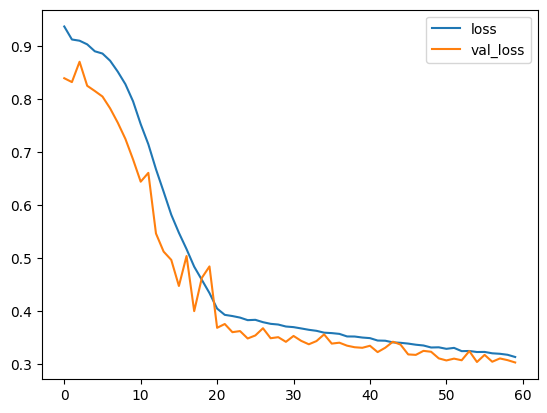

In [24]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

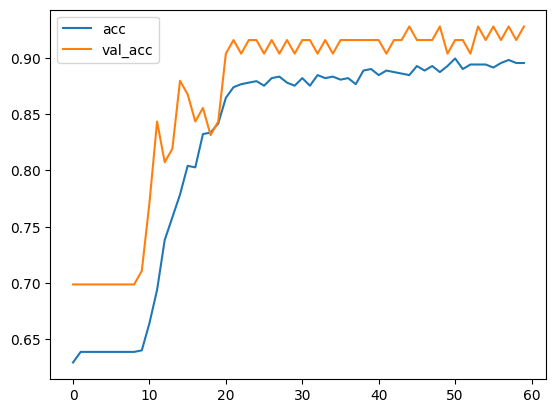

In [25]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()

3/3 [==============================] - 0s 64ms/step
              precision    recall  f1-score   support

    positive       0.94      1.00      0.97        15
     neutral       0.88      0.95      0.91        59
    negative       0.75      0.50      0.60        18

    accuracy                           0.87        92
   macro avg       0.85      0.82      0.83        92
weighted avg       0.86      0.87      0.86        92

Confusion matrix, without normalization
[[15  0  0]
 [ 0 56  3]
 [ 1  8  9]]


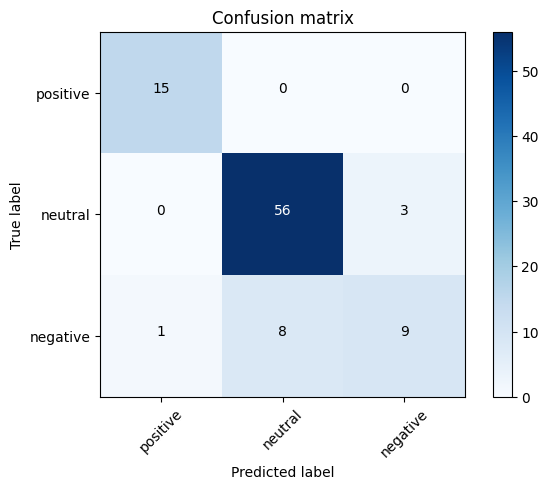

In [30]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

label_to_text = {0:'positive', 1:'neutral', 2:'negative'}


p_test = basemodel.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, p_test)
cr = classification_report(y_test, p_test, target_names=['positive', 'neutral', 'negative'])
print(cr)
plot_confusion_matrix(cm, list(label_to_text.values()))

In [27]:
checkpoint_path

'checkpoint/best_model.h5'

actual label is positive
1/1 [==============================] - 0s 21ms/step
predicted label is positive


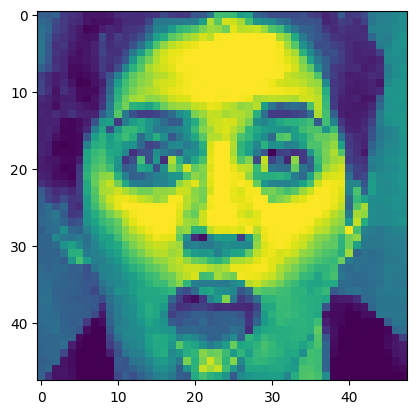

In [28]:
final_model = tf.keras.models.load_model(checkpoint_path)
from IPython.display import clear_output
import time

for k in range(40):
        print(f'actual label is {label_to_text[y_test[k]]}')
        predicted_class = final_model.predict(tf.expand_dims(X_test[k],0)).argmax()
        print(f'predicted label is {label_to_text[predicted_class]}')
        plt.imshow(X_test[k].reshape((48,48)))
        plt.show()
        time.sleep(3)
        clear_output(wait=True)